In [1]:
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
import torch
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import pickle

sns.set_theme()

In [3]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
import torch
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import argparse

device = "cpu"

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def coverage_trial(encoder, test_theta, test_x):
    test_scores = 1 / encoder.log_prob(test_theta.to(device), test_x.to(device)).detach().cpu().exp().numpy()
    return [np.sum(test_scores < conformal_quantile) / trial_sims for conformal_quantile in conformal_quantiles]

def var_coverage_trial(encoder, test_theta, test_x):
    variational_dist_samples = 100
    empirical_theta_dist = encoder.sample((variational_dist_samples), test_x)
    sample_x = np.transpose(np.tile(test_x, (variational_dist_samples,1,1)), (1, 0, 2))

    flat_empirical_theta_dist = empirical_theta_dist.reshape(-1, empirical_theta_dist.shape[-1])
    flat_sample_x = sample_x.reshape(-1, sample_x.shape[-1])
    var_probs = encoder.log_prob(flat_empirical_theta_dist, flat_sample_x).detach()
    var_log_probs = var_probs.reshape((trial_sims, -1))
    unnorm_probabilities = var_log_probs.cpu().exp().numpy()

    quantile = np.quantile(unnorm_probabilities, q = 1 - desired_coverage, method="inverted_cdf", axis=1)

    predicted_prob = encoder.log_prob(test_theta, test_x).cpu().exp().detach().numpy()
    tiled_predicted_probs = np.tile(predicted_prob.reshape(-1,1), (1,20))
    return np.sum(tiled_predicted_probs > var_quantiles, axis=0) / trial_sims

# task_names = [
#     'two_moons',
#     'slcp',
#     'gaussian_linear_uniform',
#     'bernoulli_glm',
#     'gaussian_mixture',
#     'gaussian_linear',
#     'slcp_distractors',
#     'bernoulli_glm_raw'
# ]



Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=2, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=29, bias=True)
        )
      )
      (1): LULinear()
      (2): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer):

In [69]:
task_name = 'two_moons'
task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()

total_trials = 5

trial_sims = 100 # same number for both test and calibration
sims = (total_trials + 1) * trial_sims

theta = prior.sample((sims,))
x = simulator(theta)

# very weird, but something odd happens on certain simulation runs if we generate test data at
# test time -- just generate all data (both test and calibration) ahead of time to avoid this
thetas = torch.split(theta, trial_sims)
xs = torch.split(x, trial_sims)

calibration_theta = thetas[0]
calibration_x = xs[0]

test_thetas = thetas[1:]
test_xs = xs[1:]

num_coverage_pts = 20
desired_coverages = [(1 / num_coverage_pts) * k for k in range(num_coverage_pts)]

In [65]:
epochs = [100 * i for i in range(51)]

dfs = []
for epoch in epochs:
    fn = f"{task_name}"
    cached_fn = f"{task_name}_epoch={epoch}.nf"
    with open(cached_fn, "rb") as f:
        encoder = pickle.load(f)
    encoder.to(device)

    cal_scores = 1 / encoder.log_prob(calibration_theta.to(device), calibration_x.to(device)).detach().cpu().exp().numpy()
    conformal_quantiles = np.array([np.quantile(cal_scores, q = coverage) for coverage in desired_coverages])
    conformal_quantile = conformal_quantiles[-1] # only consider alpha = 0.05 for now

    mc_set_size_ests = []
    for test_x in test_xs:
        variational_dist_samples = 500
        empirical_theta_dist = encoder.sample((variational_dist_samples), test_x)
        sample_x = np.transpose(np.tile(test_x, (variational_dist_samples,1,1)), (1, 0, 2))

        flat_empirical_theta_dist = empirical_theta_dist.reshape(-1, empirical_theta_dist.shape[-1])
        flat_sample_x = sample_x.reshape(-1, sample_x.shape[-1])
        var_probs = encoder.log_prob(flat_empirical_theta_dist, flat_sample_x).detach()
        var_log_probs = var_probs.reshape((trial_sims, -1))
        unnorm_probabilities = var_log_probs.cpu().exp().numpy()

        mc_set_size_est_all = np.sum((1 / unnorm_probabilities < conformal_quantile).astype(float) / unnorm_probabilities, axis=1) / variational_dist_samples
        mc_set_size_est = np.mean(mc_set_size_est_all)
        mc_set_size_ests.append(mc_set_size_est)
    
    df = pd.DataFrame(columns=["sizes", "epoch"])
    df["sizes"] = mc_set_size_ests
    df["epoch"] = epoch
    dfs.append(df)
df = pd.concat(dfs)
df.to_csv(f'{task_name}_sizes.csv', mode='a', header=False)

In [66]:
df

,sizes,epoch
0,36903.041148,0
1,32123.271701,0
2,30938.133373,0
3,69397.810482,0
4,40710.707848,0
0,2089.158712,500
1,2127.091171,500
2,2161.133403,500
3,2168.130535,500
4,2202.029786,500


<Axes: xlabel='epoch', ylabel='sizes'>

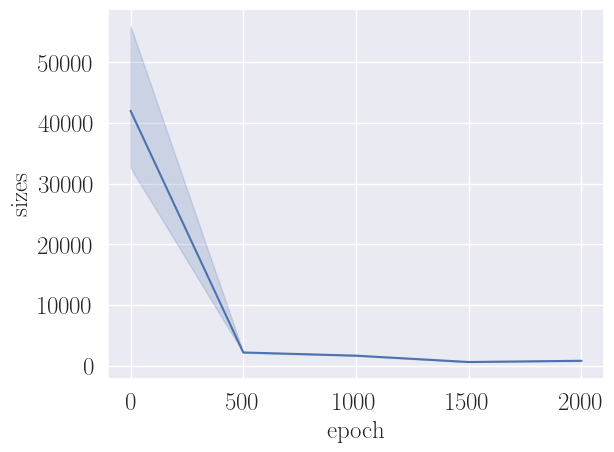

In [67]:
sns.lineplot(data=df, x="epoch", y="sizes")

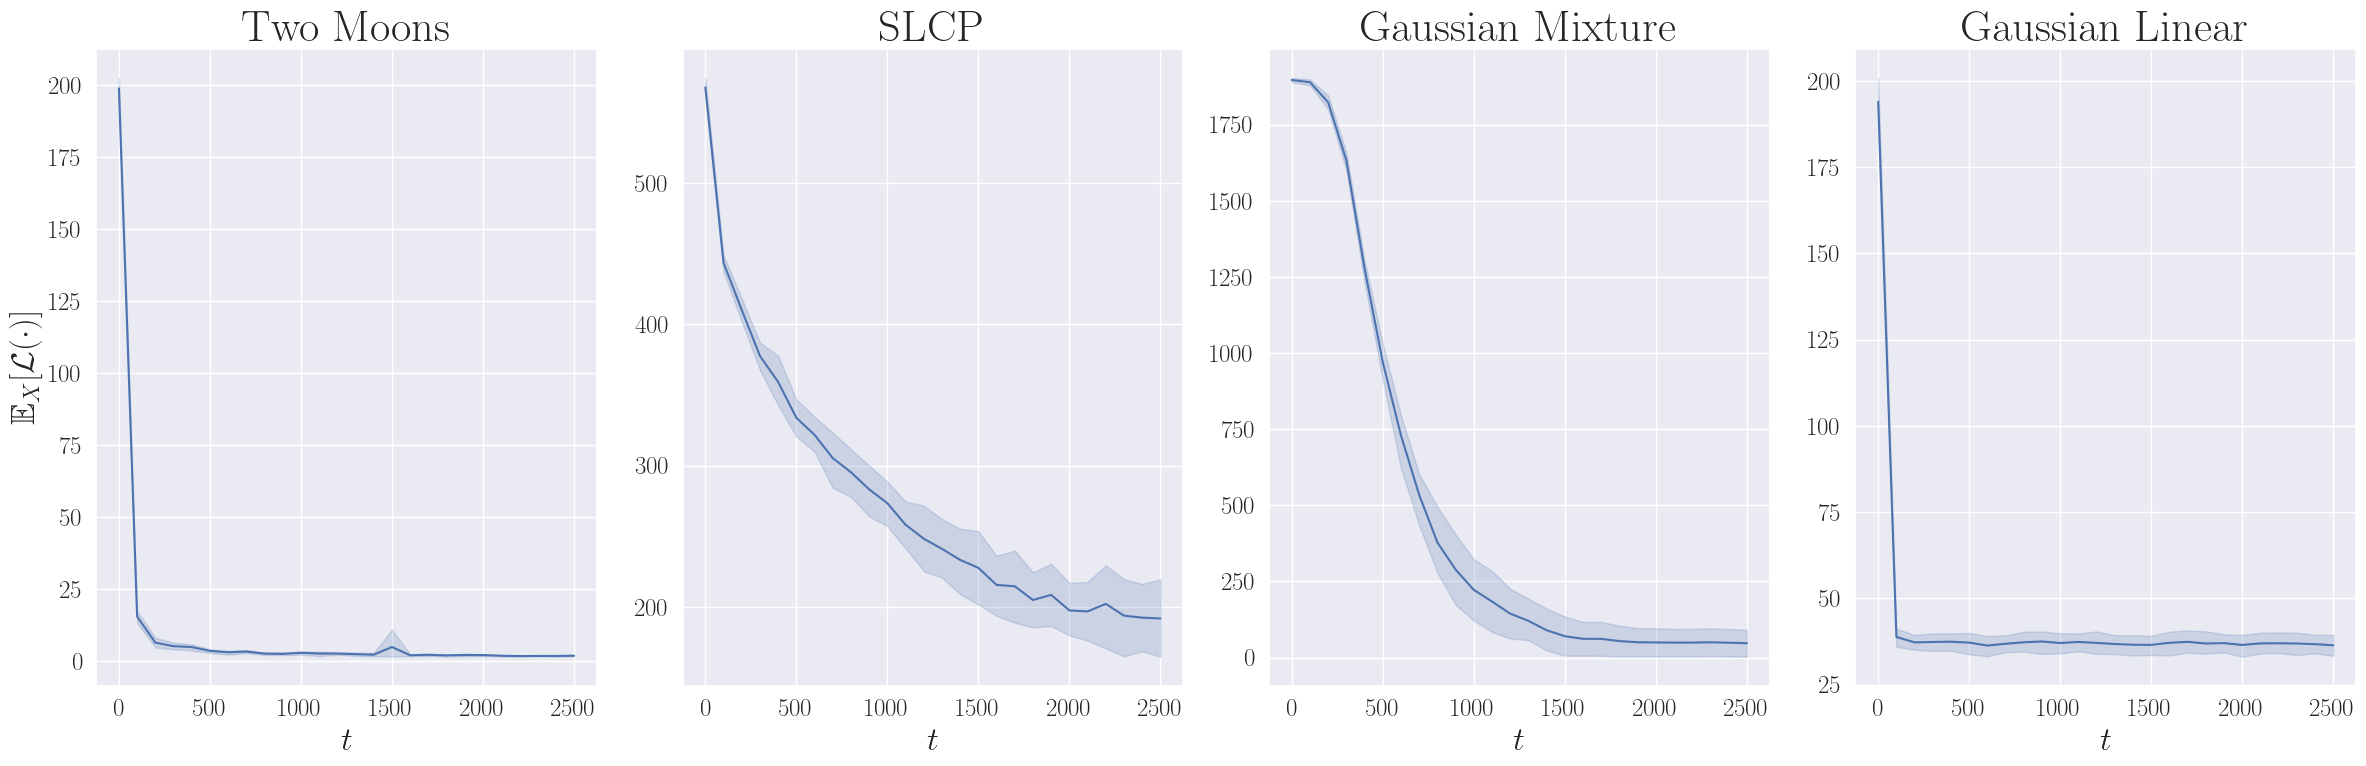

In [9]:
task_names = [
    'two_moons',
    'slcp',
    'gaussian_mixture',
    'gaussian_linear',
]

task_name_titles = [
    'Two Moons',
    'SLCP',
    'Gaussian Mixture',
    'Gaussian Linear',
]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24,8))
# axs[0].set_ylabel("$\mathbb{E}_X[\mathcal{L}(\cdot)]$",fontsize=24)
for i, task_name in enumerate(task_names):
    df = pd.read_csv(f'{task_name}.csv', header=None, index_col=0)
    axs[i].set_title(task_name_titles[i], fontsize=32)
    axs[i].set_xlabel(r"$t$",fontsize=24)

    # if i % 2 == 1:
    #     axs[i].set_xlabel(r"$t$",fontsize=24)
    # else:
    #     axs[i].set_xlabel(" ")

    if i == 0:
        axs[i].set_ylabel("$\mathbb{E}_X[\mathcal{L}(\cdot)]$",fontsize=24)
    else:
        axs[i].set_ylabel(" ")

    sns.lineplot(data=df, x=1, y=2, ax=axs[i])

plt.tight_layout()
plt.savefig(f"sbi_set_sizes.png")